# Исследование стоимости продажи электроэнергии производства ТЭЦ

Описание данных<br>
ЦЗ (ценовая зона) – в данном случае рассматривается только ценовая зона «Европа». Территориально ценовая зона «Европа» включает в себя Европейскую часть и Урал.<br>
ЗСП (зона свободного перетока) – некоторая территория, которая состоит из субъектов Российской Федерации или их частей. В разбивке по ЗСП представлены цена продажи электроэнергии и некоторые объемные параметры. Последние две цифры в коде ЗСП соответствуют номеру, указанному на карте. Территории, которые не обозначены цифровым кодом на карте к ценовой зоне «Европа» не относятся.<br>
План ГЭС (МВт*ч) – плановый объем производства электроэнергии ГЭС (гидроэлектростанции) в ЗСП.<br>
План АЭС (МВт*ч) – плановый объем производства электроэнергии АЭС (атомной электростанцией) в ЗСП.<br>
План ТЭС (МВт*ч) – плановый объем производства электроэнергии ТЭС (тепловой электростанцией) в ЗСП. К тепловым электростанциям относятся все электростанции, которые производят электроэнергию путем сжигания органического топлива (газ, уголь, мазут).<br>
ТЭС мин (МВт*ч) – технологически минимальная мощность включенного в работу теплового генерирующего оборудования в ЗСП.<br>
ТЭС макс (МВт*ч) – технологически максимальная мощность включенного в работу теплового генерирующего оборудования в ЗСП.<br>
Потребление (МВт*ч) – плановый объем потребления электроэнергии, заявленный потребителями в ЗСП.<br>
Экспорт/Импорт (МВт*ч) – плановый объем перетока электроэнергии между соседними ЗСП. Экспорт – переток электроэнергии из данной ЗСП в соседние. Импорт – переток электроэнергии в данную ЗСП из соседних.<br>
План СЭС, ВЭС, ВИЭ (МВт*ч) – плановый объем производства электроэнергии солнечными, ветровыми и другими ВИЭ в данной ЗСП соответственно.<br>
<br><br>
Ценопринимающее предложение (МВт*ч) – объем электроэнергии, в отношении которого поставщики в ценовой заявке на отбор заявляют цену равную нулю. При этом на объем мощности соответствующей технологически минимальной мощности поставщики обязаны подать ценопринимающую заявку. Данная величина фиксируется только по ценовой зоне.<br>
Ценопринимание сверх минимальной мощности (МВт*ч) – объем электроэнергии, в отношении которого поставщик в ценовой заявке на отбор заявил цену равную нулю. При этом на указанный объем у поставщика не было требования подавать ценопринимание. Данное действие является часть его ценовой стратегии.
Цена продажи электроэнергии (руб./МВт*ч) – параметр, который необходимо спрогнозировать.


In [4]:
# !pip install catboost

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from itertools import product
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from scipy.stats import probplot

import warnings
warnings.filterwarnings('ignore')


In [6]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(12,8)

Dataset

https://docs.google.com/spreadsheets/d/1z-jKX5eYkGbfsW91I-uevfUYhXalOFAD/edit?usp=sharing&ouid=105588548640069276199&rtpof=true&sd=true

https://docs.google.com/spreadsheets/d/1E690TtwqzqWBxFNjGLiO6Hd_mOxz2bbQ/edit?usp=sharing&ouid=105588548640069276199&rtpof=true&sd=true

https://docs.google.com/spreadsheets/d/1pq__kLdURqld-fXlUVVbsSz5_o8UJ_ln/edit?usp=sharing&ouid=105588548640069276199&rtpof=true&sd=true

In [7]:
! gdown --id 1z-jKX5eYkGbfsW91I-uevfUYhXalOFAD
! gdown --id 1E690TtwqzqWBxFNjGLiO6Hd_mOxz2bbQ
! gdown --id 1pq__kLdURqld-fXlUVVbsSz5_o8UJ_ln

Downloading...
From: https://drive.google.com/uc?id=1z-jKX5eYkGbfsW91I-uevfUYhXalOFAD
To: /content/2018.xlsx
100% 14.9M/14.9M [00:00<00:00, 193MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E690TtwqzqWBxFNjGLiO6Hd_mOxz2bbQ
To: /content/2019.xlsx
100% 15.0M/15.0M [00:00<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pq__kLdURqld-fXlUVVbsSz5_o8UJ_ln
To: /content/2020.xlsx
100% 9.66M/9.66M [00:00<00:00, 66.2MB/s]


In [8]:
df_2018 = pd.read_excel('/content/2018.xlsx')
df_2019 = pd.read_excel('/content/2019.xlsx')
df_2020 = pd.read_excel('/content/2020.xlsx')

In [9]:
df = pd.concat([df_2018, df_2019, df_2020])

In [10]:
df.shape[0] == df_2018.shape[0] + df_2019.shape[0] + df_2020.shape[0] 

True

In [11]:
df.shape[0]

348120

In [12]:
df.head()

,Дата,ЦЗ,ЗСП,Час,"План ГЭС, МВт*ч","План АЭС, МВт*ч","План ТЭС, МВт*ч","ТЭС мин, МВт*ч","ТЭС макс, МВт*ч","Потребление, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч","План СЭС, МВт*ч","План ВЭС, МВт*ч","План ВИЭ, МВт*ч","Ценопринимающее предложение, МВт*ч","Ценопринимание сверх минимальной мощности, МВт*ч","Цена продажи, руб./МВт*ч"
0,2018-01-01 00:00:00.000,Европа,FZUROE07,8,145.6,616.0,15310.118,12985.703,18417.555,16133.167,1724.097,2122.273,8.3,0.0,0,82858.55,6103.482,776.25
1,2018-01-01 00:00:00.000,Европа,FZURTU08,8,0.0,0.0,11906.500,8014.692,12166.200,9971.934,1658.871,29.774,0.0,0.0,0,82858.55,6103.482,685.40
2,2018-01-01 00:00:00.000,Европа,FZVLBS15,8,120.0,4073.0,576.000,576.000,640.000,1375.474,3260.660,1.122,0.6,0.0,0,82858.55,6103.482,781.87
3,2018-01-01 00:00:00.000,Европа,FZVLOE13,8,500.0,49.5,3857.360,3777.730,4461.390,5812.795,1369.469,2873.540,0.0,3.5,0,82858.55,6103.482,823.30
4,2018-01-01 00:00:00.000,Европа,FZYUAS18,8,0.0,0.0,431.500,326.297,531.500,532.284,30.329,154.762,2.0,0.0,0,82858.55,6103.482,890.73


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348120 entries, 0 to 85319
Data columns (total 18 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   Дата                                              348120 non-null  object 
 1   ЦЗ                                                348120 non-null  object 
 2   ЗСП                                               348120 non-null  object 
 3   Час                                               348120 non-null  int64  
 4   План ГЭС, МВт*ч                                   348120 non-null  float64
 5   План АЭС, МВт*ч                                   348120 non-null  float64
 6   План ТЭС, МВт*ч                                   348120 non-null  float64
 7   ТЭС мин, МВт*ч                                    348120 non-null  float64
 8   ТЭС макс, МВт*ч                                   348120 non-null  float64
 9   Потре

Пропущенных значений нет

In [14]:
cols = [col.replace(', МВт*ч', '').replace(', руб./МВт*ч', '') for col in df.columns]
df = df.set_axis(cols, axis=1)

In [15]:
df['Дата'] = pd.to_datetime(df['Дата'], format='%Y-%m-%d')

In [16]:
df.describe()

,Час,План ГЭС,План АЭС,План ТЭС,ТЭС мин,ТЭС макс,Потребление,Экспорт,Импорт,План СЭС,План ВЭС,План ВИЭ,Ценопринимающее предложение,Ценопринимание сверх минимальной мощности,Цена продажи
count,348120.000000,348120.000000,348120.000000,348120.000000,348120.000000,348120.000000,348120.000000,348120.000000,348120.000000,348120.000000,348120.000000,348120.0,348120.000000,348120.000000,348120.000000
mean,11.500000,534.579729,1560.423622,3913.613816,3025.442917,4477.095770,5747.527248,1515.225917,1427.516439,9.413483,2.601912,0.0,82868.075808,5942.294245,1210.504163
std,6.922196,589.854930,2864.368336,4614.163288,3473.175531,5119.145413,5490.538708,1575.233978,1613.499768,33.015642,11.773395,0.0,9449.684294,1913.176434,334.550235
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,272.739000,0.000000,0.000000,0.000000,0.000000,0.0,60738.470000,549.586000,0.000000
25%,5.750000,0.000000,0.000000,460.000000,316.797000,529.500000,1339.953250,357.358000,148.646000,0.000000,0.000000,0.0,75799.482500,4499.906750,950.260000
50%,11.500000,420.038500,0.000000,1985.300000,1746.047000,2561.475000,3887.482500,1076.284000,765.579500,0.000000,0.000000,0.0,81738.275000,6171.876000,1198.060000
75%,17.250000,803.395250,2560.000000,5665.560500,4715.001500,6925.674000,8664.962500,2203.083750,2148.790500,0.000000,0.000000,0.0,90519.395000,7489.637250,1447.870000
max,23.000000,2840.000000,14296.300000,19972.015000,15233.215000,21662.428000,22276.396000,8633.122000,7994.177000,309.690000,308.175000,0.0,105886.440000,10423.557000,6119.060000


In [17]:
df['ЦЗ'].value_counts()

Европа        348120
Name: ЦЗ, dtype: int64

In [18]:
df['ЗСП'].value_counts()

FZUROE07      23208
FZURTU08      23208
FZVLBS15      23208
FZVLOE13      23208
FZYUAS18      23208
FZYUDA23      23208
FZYUKU20      23208
FZYUOE16      23208
FZYUVG17      23208
FZZMSK26      23208
FZSZKO28      23208
FZSZOE27      23208
FZURKR12      23208
FZZNOE24      23208
FZURNT09      23208
Name: ЗСП, dtype: int64

Все представленные данные принадлежат зоне "Европа"

In [19]:
df.duplicated().sum()

0

Дубликатов нет

In [20]:
pd.date_range(start = df['Дата'].min(), end = df['Дата'].max() ).difference(df['Дата'])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Пропущенных дат нет

In [21]:
df['Дата'].dt.day_name().value_counts()

Monday       50040
Tuesday      49680
Wednesday    49680
Thursday     49680
Friday       49680
Saturday     49680
Sunday       49680
Name: Дата, dtype: int64

# EDA

Посмотрим подробнее на целевую переменную

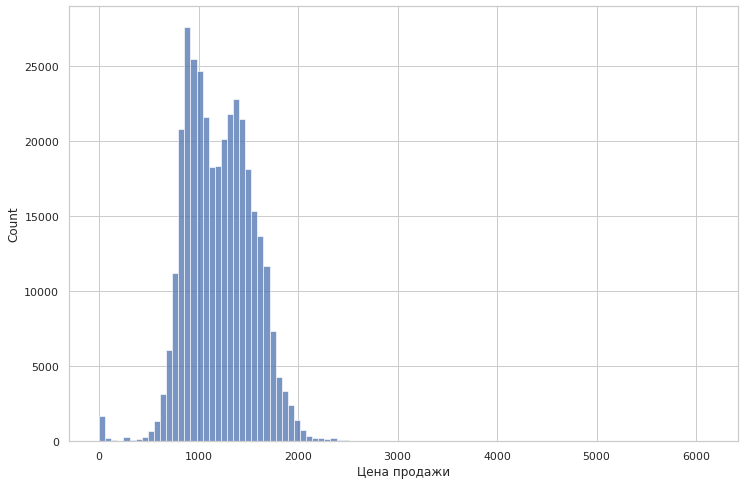

In [22]:
sns.histplot(df['Цена продажи'], bins = 100)

Видим, что данные имеют бимодальное, похожее на нормальное распределение с хвостом, а так же еще один пик в 0

Некоторые зоны, в особенности FZSZKO28, имеют нулевые значения цены продажи.<br>
Это предмет будущих исследований

---



In [23]:
df[df['Цена продажи'] == 0]['ЗСП'].value_counts()

FZSZKO28      332
FZYUOE16       34
FZYUDA23       31
FZYUAS18       15
FZYUVG17       14
FZYUKU20       13
FZVLBS15       12
FZSZOE27        9
FZURNT09        9
FZZMSK26        5
FZZNOE24        4
FZURTU08        2
FZURKR12        2
FZVLOE13        2
FZUROE07        1
Name: ЗСП, dtype: int64

In [24]:
df[df['Цена продажи'] == 0]['Дата'].value_counts().head(15)

2020-05-25    28
2019-05-27    24
2019-05-26    24
2019-09-01    17
2018-07-02    17
2019-10-16    17
2020-05-26    16
2018-06-05    15
2019-11-01    14
2020-08-01    14
2019-06-13    13
2020-06-02    12
2020-05-03    11
2020-07-10    10
2018-05-07     9
Name: Дата, dtype: int64

In [25]:
df[df['Цена продажи'] == 0]['Дата'].dt.weekday.value_counts()

0    96
1    80
5    76
6    72
2    69
4    50
3    42
Name: Дата, dtype: int64

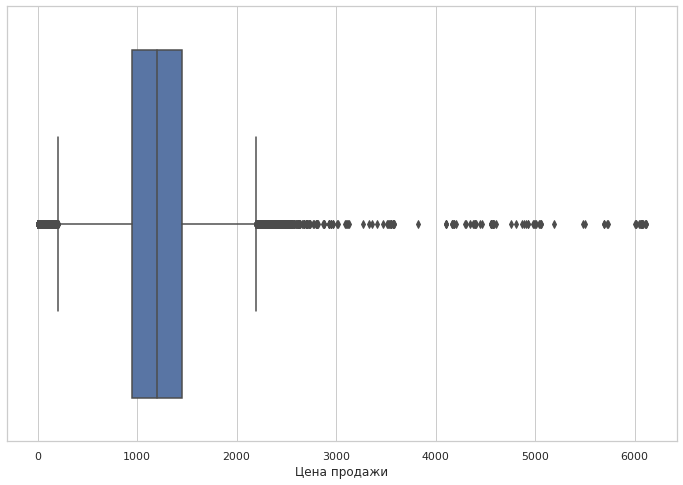

In [26]:
sns.boxplot(df['Цена продажи']);

Видно, что в целевой переменной присутствуют выбросы.

Сгруппируем датасет по дате, будем дальше работать с сгруппированным датафреймом, и со средними значениями цены продажи за день т.к. предсказывать нам нужно среднее значение за день.

In [27]:
df = df.groupby('Дата').agg({'План ГЭС':'mean', 'План АЭС':'mean', 'План ТЭС':'mean','Потребление':'mean', 'Экспорт':'mean', 'Импорт':'mean',
                                 'ТЭС мин':'mean', 'ТЭС макс':'mean','План СЭС':'mean', 'План ВЭС':'mean', 'План ВИЭ':'mean', 
                                 'Ценопринимающее предложение':'mean','Ценопринимание сверх минимальной мощности':'mean','Цена продажи': 'mean'}).copy()

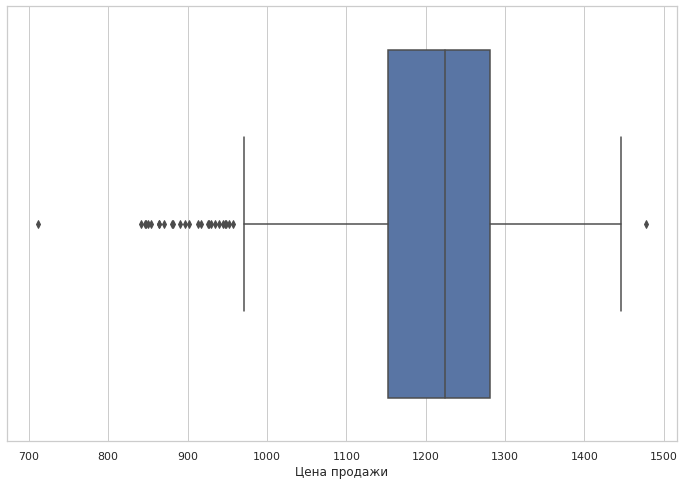

In [28]:
sns.boxplot(df['Цена продажи']);

Выбросы остались, но уже только в отрицательную сторону.<br>
Пока что у нас нет интуиции насчет природы этих выбросов, поэтому оставим их как есть.

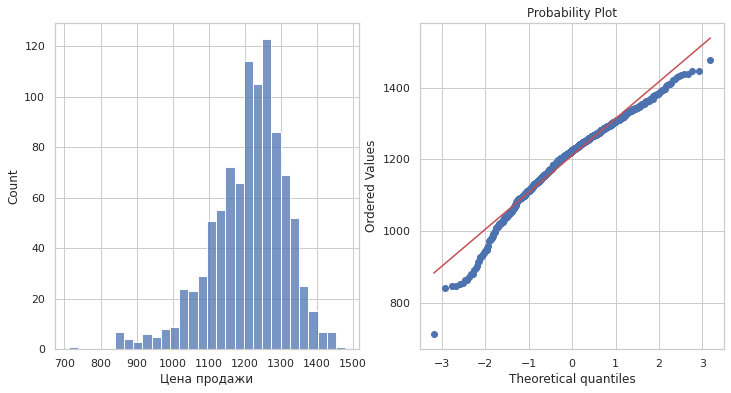

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.histplot(df['Цена продажи'], bins = 30, ax=ax[0])
probplot(df['Цена продажи'], dist='norm',plot=ax[1]);

Благодаря ЦПТ получили близкое к нормальному распределение дневных средних цен продажи.

Посмотрим на корреляцию признаков

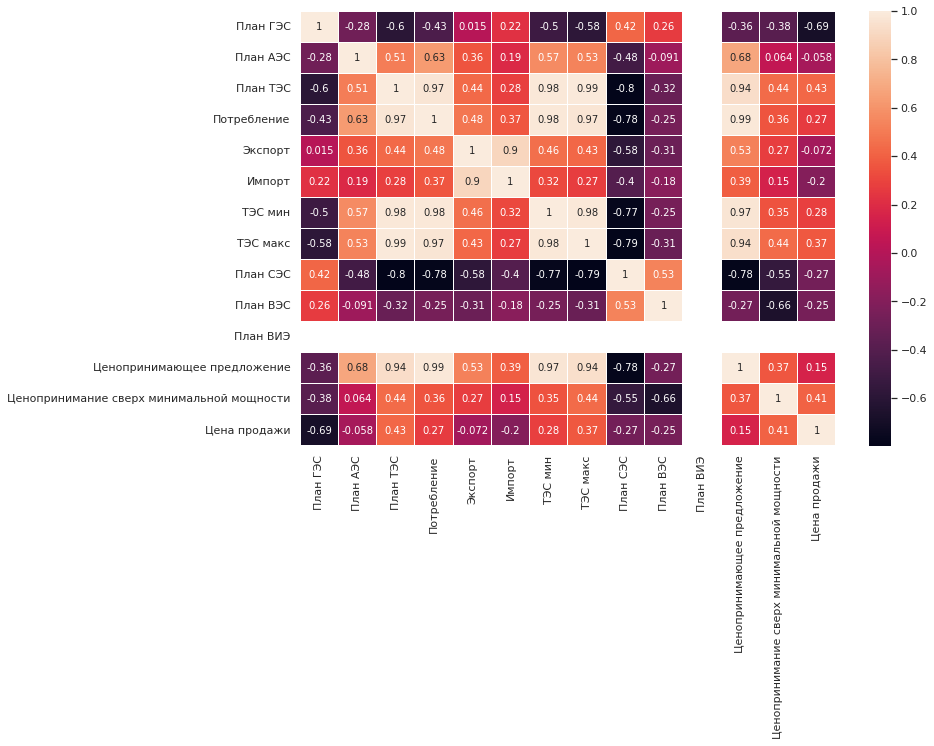

In [30]:
sns.heatmap(df.corr(),annot=True, linewidths=0.1, annot_kws={"fontsize":10} );

Видно, что большое кол-во признаков имеют линейную зависимость с целевой переменной.

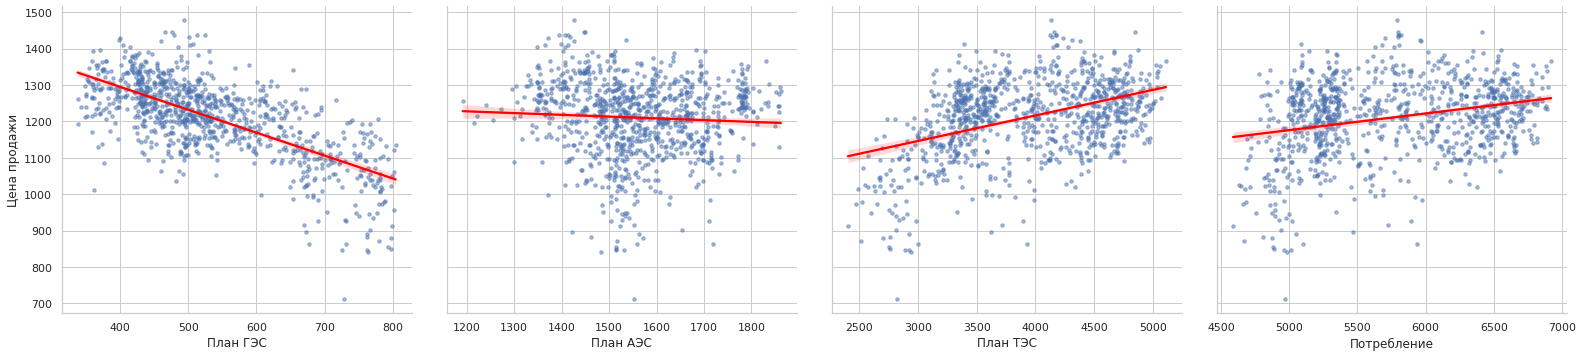

In [31]:
g = sns.pairplot(df, kind='reg', x_vars=['План ГЭС','План АЭС', 'План ТЭС','Потребление'],y_vars = ['Цена продажи'], plot_kws={'scatter_kws': {'s': 12, 'alpha': 0.5, }, 'line_kws':{'color':'red'}})
g.fig.set_size_inches(24,6)

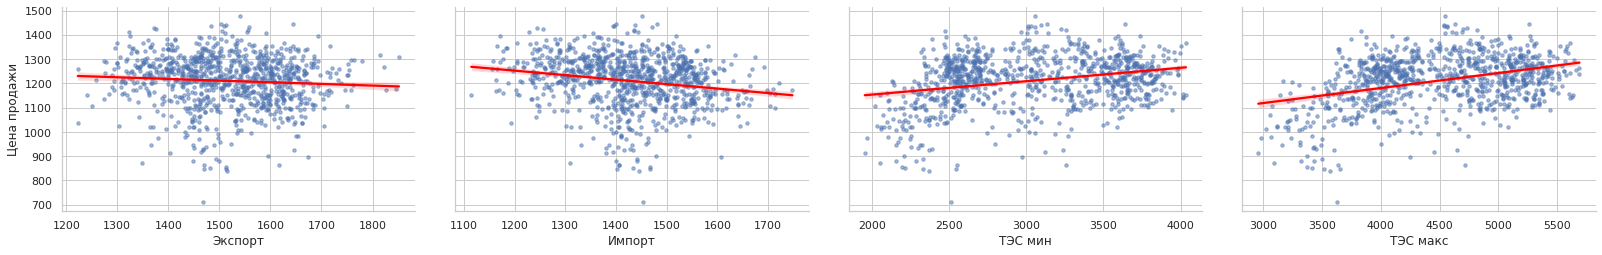

In [32]:
g = sns.pairplot(df, kind='reg', x_vars=['Экспорт', "Импорт", 'ТЭС мин','ТЭС макс'],y_vars = ['Цена продажи'], plot_kws={'scatter_kws': {'s': 12, 'alpha': 0.5, }, 'line_kws':{'color':'red'}})
g.fig.set_size_inches(24,4)

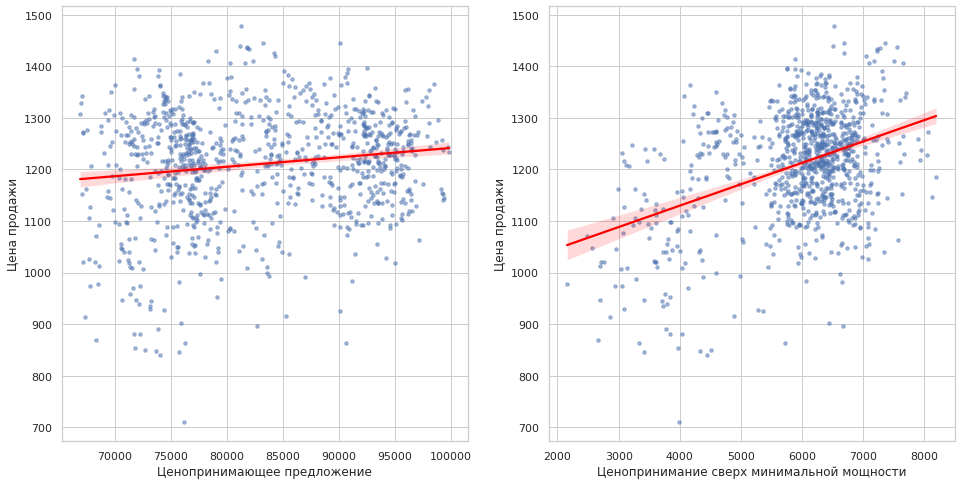

In [33]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
sns.regplot(data=df, x = 'Ценопринимающее предложение', y= 'Цена продажи', ax=ax[0], scatter_kws ={'s': 12, 'alpha': 0.5, }, line_kws= {'color':'red'})
sns.regplot(data=df, x = 'Ценопринимание сверх минимальной мощности', y= 'Цена продажи', ax=ax[1], scatter_kws ={'s': 12, 'alpha': 0.5, }, line_kws= {'color':'red'})

In [34]:
df.groupby(df.index.day_name())['Цена продажи'].agg(['count','mean','median'])

,count,mean,median
Дата,,,
Friday,138,1226.644529,1243.993083
Monday,139,1215.750139,1234.301583
Saturday,138,1229.431753,1236.388361
Sunday,138,1164.526087,1185.972526
Thursday,138,1219.800705,1228.807264
Tuesday,138,1200.280422,1211.125819
Wednesday,138,1217.057490,1226.941014


В среднем, цена продажи стабильная по дням, так же видим что медиана не слишком далека от среднего, значит существующие выбросы сильного влияния не оказывают.

### Подготовим тренировочный, тестовый и валидационный наборы данных

In [35]:
def train_test_valide(df, test_days, val_days, target):
  """Получает значения в количестве дней для разбиения датасета"""
  train_idx = test_days + val_days
  X_train = df.iloc[:-train_idx].drop(target, axis=1)
  y_train = df[target].iloc[:-train_idx]
  X_test = df.iloc[-train_idx:-val_days].drop(target, axis=1)
  y_test = df[target].iloc[-train_idx:-val_days]
  X_valid = df.iloc[-val_days:].drop(target, axis=1)
  y_valid = df[target].iloc[-val_days:]

  return X_train, y_train, X_test, y_test, X_valid, y_valid

In [36]:
X_train, y_train, X_test, y_test, X_valid, y_valid = train_test_valide(df, 180, 30, 'Цена продажи')

In [37]:
print(X_train.index.min())
print(X_train.index.max())

2018-01-01 00:00:00
2020-01-27 00:00:00


In [38]:
print(X_test.index.min())
print(X_test.index.max())

2020-01-28 00:00:00
2020-07-25 00:00:00


In [39]:
print(X_valid.index.min())
print(X_valid.index.max())

2020-07-26 00:00:00
2020-08-24 00:00:00


In [40]:
X_train.shape[0] + X_test.shape[0] + X_valid.shape[0] == df.shape[0]

True

In [41]:
y_train.shape[0] + y_test.shape[0] + y_valid.shape[0] == df.shape[0]

True

Функция оценки

In [42]:
def metrics(y_true, y_pred):
  """Возвращает значения ошибки MSE, MAE и MAPE средней дневной продажи"""
  eps = np.finfo(np.float64).eps

  
  MAE = np.round(mean_absolute_error(y_true, y_pred),2)
  MAPE = np.round(mean_absolute_percentage_error(y_true, y_pred)*100, 2)
  RMSE = np.round(np.sqrt(mean_squared_error(y_true, y_pred)),2)

  return pd.Series({
        'Абсолютное значение отклонения цены продажи, MAE': MAE,
        'Средний процент отклонения цены продажи, MAPE': MAPE,
        'Отклонение цены продажи, RMSE': RMSE
    })

#Baseline

Наивный алгоритм будет везде предсказывать среднее значение цены продажи

In [43]:
baseline_mean = y_train.mean()

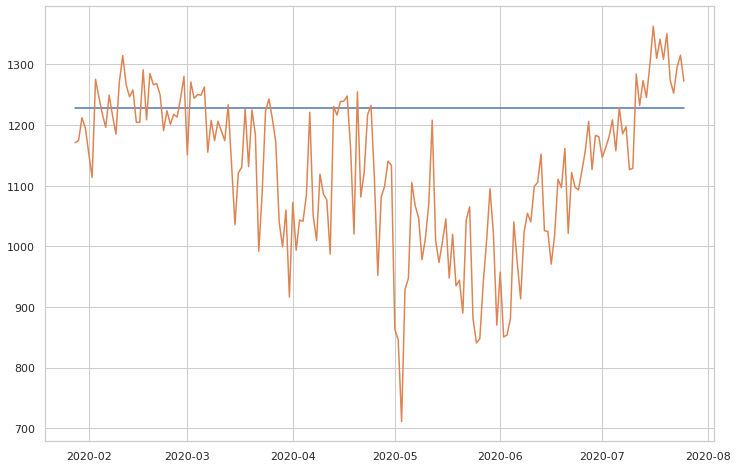

In [44]:
count = y_test.shape[0]
plt.subplot()
plt.plot(pd.DataFrame({'idx':y_test.index, 'values':[baseline_mean]*count}).set_index('idx'))
plt.plot(y_test)

In [45]:
metrics(y_test, [baseline_mean]*count)

Абсолютное значение отклонения цены продажи, MAE    120.97
Средний процент отклонения цены продажи, MAPE        12.00
Отклонение цены продажи, RMSE                       161.07
dtype: float64

Видим, что предсказывая среднее, ошибаемся на 12% или на 120 рублей в абсолютном значении

# Линейная регрессия

In [46]:
ALPHAS = [0.001, 0.01, 0.1, 1, 5]
params = {'model__l1_ratio':[0,0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 1],
          'model__eps':[0.001, 0.01, 0.1, 1],
          'model__max_iter':[100,1000,5000],
          'model__tol':[0.0001, 0.001, 0.01, 0.1]}

In [47]:
elastic_model = ElasticNetCV(alphas=ALPHAS, cv=3)

In [48]:
def linear_regression(estimator,X,y, reg_alphas, grid_search_params):
  selector = RFE(estimator)

  pipeline = Pipeline([
            #('selection', selector),
            ('scaler', StandardScaler()),
            ('model', estimator)
  ])

  grid_search = GridSearchCV(pipeline, grid_search_params, n_jobs=-1)
  grid_search.fit(X,y)
  print("Best parameter", grid_search.best_score_)

  return grid_search


In [49]:
lr = linear_regression(elastic_model,X_train, y_train, ALPHAS, params);

Best parameter 0.6215364327530594


In [50]:
lr.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 5], cv=3, l1_ratio=1,
                              max_iter=5000))])

In [51]:
metrics(y_test, lr.predict(X_test))

Абсолютное значение отклонения цены продажи, MAE    68.00
Средний процент отклонения цены продажи, MAPE        6.66
Отклонение цены продажи, RMSE                       88.52
dtype: float64

In [52]:
metrics(y_valid, lr.predict(X_valid))

Абсолютное значение отклонения цены продажи, MAE    41.10
Средний процент отклонения цены продажи, MAPE        3.38
Отклонение цены продажи, RMSE                       50.12
dtype: float64

#### Видим, что модель имеет неплохую обобщающую способность.<br> В среднем на тестовой выборке мы ошибаемся на 6.5% или на 68 рублей

#### Посмотрим на график

In [53]:
true_y_test_valid = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_valid)])

In [54]:
test_predictions = pd.DataFrame({'Date':X_test.index,'Cost_pred':lr.predict(X_test) }).set_index('Date')
valid_predictions = pd.DataFrame({'Date':X_valid.index, 'Cost_pred':lr.predict(X_valid)}).set_index('Date')

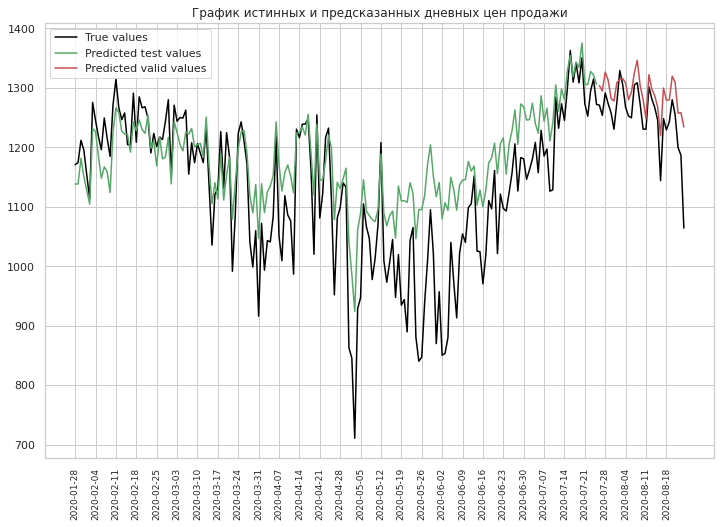

In [55]:
#import matplotlib.dates as mdates
plt.subplot()

true = plt.plot(true_y_test_valid.index, true_y_test_valid, color='black', label='True values')
test = plt.plot(test_predictions.index,test_predictions,color='g', label='Predicted test values')
valid = plt.plot(valid_predictions.index, valid_predictions,color='r', label='Predicted valid values')

plt.xticks(true_y_test_valid.index[::7], fontsize=9, rotation=90)

plt.title('График истинных и предсказанных дневных цен продажи')
plt.legend()
plt.show()

Последний день подвел :)<br>
Видим ошибку практически в 113 рублей<br>
Модель не ожидала такого сильного падения цены

# Catboost

In [56]:
cb = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    #task_type="GPU",     
    iterations=5000,
    early_stopping_rounds=50
)

In [57]:
grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'depth': [1, 2, 4, 6, 8],
        'l2_leaf_reg': [0.05, 0.2, 0.5, 1, 3]
}

In [ ]:
grid_search_result = cb.grid_search(grid, X_train, y_train, shuffle = False);

In [59]:
metrics(y_test, cb.predict(X_test))

Абсолютное значение отклонения цены продажи, MAE     77.67
Средний процент отклонения цены продажи, MAPE         7.54
Отклонение цены продажи, RMSE                       101.60
dtype: float64

Видим приблизительно тот же показатель, как и у линейной регрессии.

Линейная регрессия и градиентный бустинг использовали данные, поступающие каждый день, перед днем, для которого нужно спрогнозировать значение.<br>
Значит прогноз на 30 дней вперед ориентируясь на эти данные мы построить не можем.<br>
Применим модель Хольта-Уинтерса для прогнозирования временного ряда

#Exponential Smoothing

Еще раз посмотрим на ряд

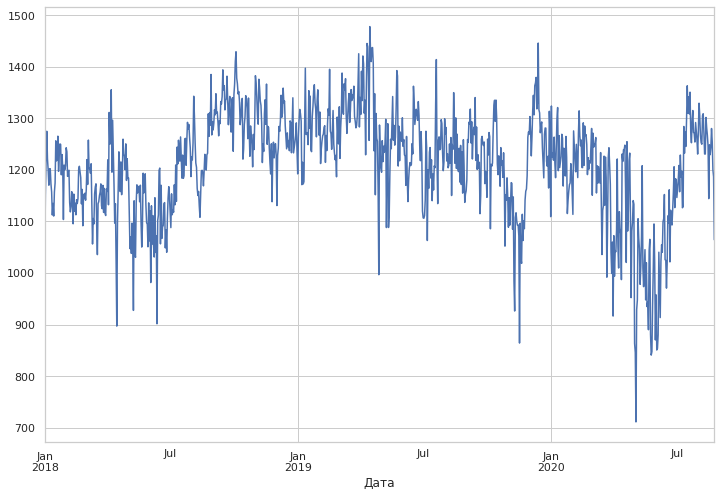

In [60]:
df['Цена продажи'].plot()

Декомпозируем ряд на тренд и сезонность

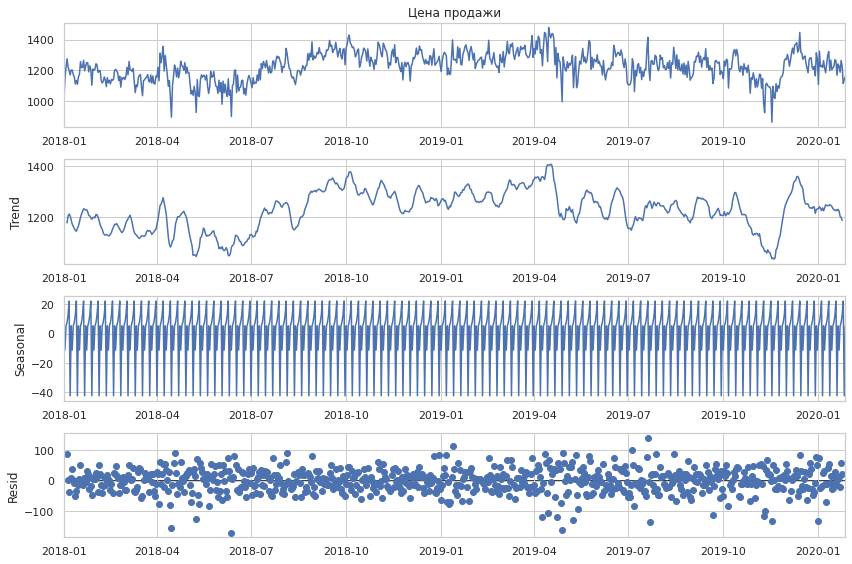

In [61]:
decompose = seasonal_decompose(y_train)
decompose.plot()
 
plt.show()

Видим недельную сезонность и тренд

In [62]:
from itertools import product
feats_init = np.array(['add', 'mul'])
feats = [p for p in product(feats_init, repeat = 2)]

In [63]:
for i in feats:
  print(i)
  halt = ExponentialSmoothing(y_train, seasonal_periods=365, trend=i[0], seasonal=i[1],).fit()
  fitted_values = halt.fittedvalues
  test_predictions = pd.DataFrame({'Date':y_test.index,'Cost_pred': halt.predict(start = y_test.index.min(), end =y_test.index.max())}).set_index('Date')
  print(metrics(y_test, test_predictions))

('add', 'add')
Абсолютное значение отклонения цены продажи, MAE    125.66
Средний процент отклонения цены продажи, MAPE        11.16
Отклонение цены продажи, RMSE                       149.34
dtype: float64
('add', 'mul')
Абсолютное значение отклонения цены продажи, MAE    116.62
Средний процент отклонения цены продажи, MAPE        11.16
Отклонение цены продажи, RMSE                       144.51
dtype: float64
('mul', 'add')
Абсолютное значение отклонения цены продажи, MAE    121.99
Средний процент отклонения цены продажи, MAPE        11.40
Отклонение цены продажи, RMSE                       146.14
dtype: float64
('mul', 'mul')
Абсолютное значение отклонения цены продажи, MAE    131.44
Средний процент отклонения цены продажи, MAPE        12.67
Отклонение цены продажи, RMSE                       163.94
dtype: float64


In [64]:
halt = ExponentialSmoothing(y_train, seasonal_periods=365, trend='add', seasonal='mul').fit()
fitted_values = halt.fittedvalues
test_predictions = pd.DataFrame({'Date':y_test.index,'Cost_pred': halt.predict(start = y_test.index.min(), end =y_test.index.max())}).set_index('Date')

In [65]:
metrics(y_test, test_predictions)

Абсолютное значение отклонения цены продажи, MAE    116.62
Средний процент отклонения цены продажи, MAPE        11.16
Отклонение цены продажи, RMSE                       144.51
dtype: float64

Чуть лучше константного предсказания, но тренд и сезонность улавливает

Посмотрим график

In [66]:
test_predictions= pd.DataFrame({'Date':y_test.index,'Cost_pred': halt.predict(start = y_test.index.min(), end =y_test.index.max())}).set_index('Date')
valid_predictions=pd.DataFrame({'Date':y_valid.index,'Cost_pred': halt.predict(start = y_valid.index.min(), end =y_valid.index.max())}).set_index('Date')

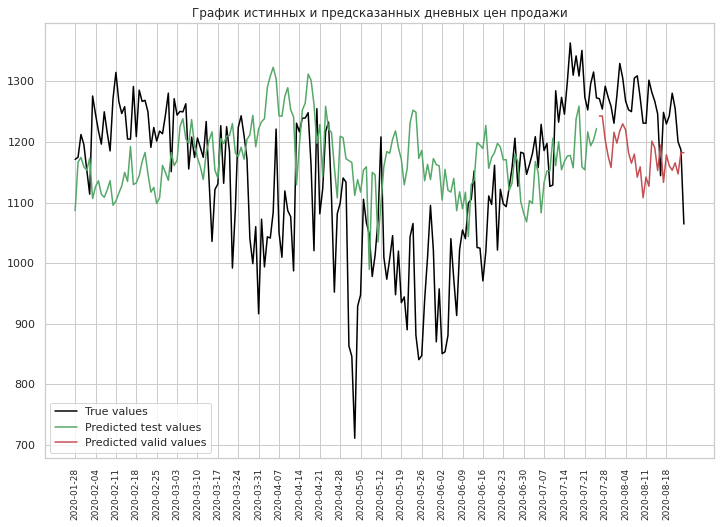

In [67]:
plt.subplot()

#plt.plot(y_train)
true = plt.plot(true_y_test_valid.index, true_y_test_valid, color='black', label='True values')
test = plt.plot(test_predictions.index,test_predictions,color='g', label='Predicted test values')
valid = plt.plot(valid_predictions.index, valid_predictions,color='r', label='Predicted valid values')

plt.xticks(true_y_test_valid.index[::7], fontsize=9, rotation=90)

plt.title('График истинных и предсказанных дневных цен продажи')
plt.legend()
plt.show()

# ARIMA

Приведем ряд к стационарному и скорректируем дисперсию трансформацией Бокса Кокса

In [68]:
def invboxcox(y,lmbda):
    """ обрабтное преобразование Бокса-Кокса """
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [69]:
adf = adfuller(y_train)
ADF_stat = adf[0]
p_val = adf[1]
print('ADF Statistic:', ADF_stat, 'p_value:', p_val)

ADF Statistic: -2.7935499595893587 p_value: 0.05920103356043438


P value > 0.05, это значит что мы не можем отвергнуть 0 гипотезу, которая говорит нам о нестационарности ряда.

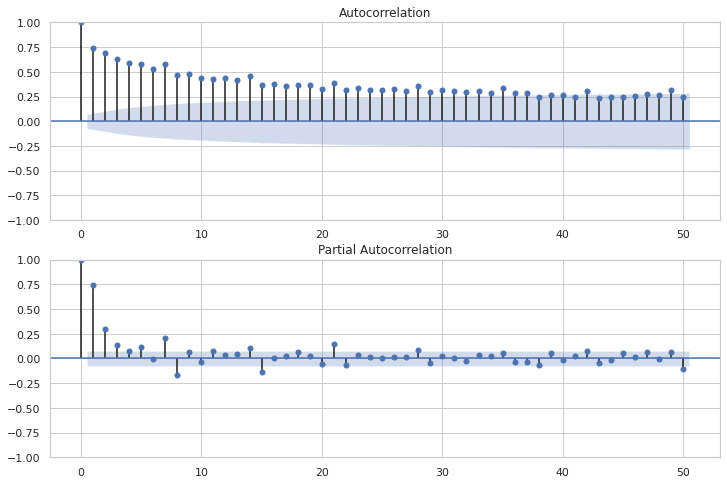

In [70]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(y_train, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_train, lags=50, ax=ax[1])

plt.show()

Видим сильный тренд

Применим трансформацию Бокса Кокса, чтобы уменьшить дисперсию

In [71]:
y_train_bc, lmbda = boxcox(y_train)
y_train_bc = pd.Series(y_train_bc, index=y_train.index)

In [72]:
adf = adfuller(y_train_bc)
ADF_stat = adf[0]
p_val = adf[1]
print('ADF Statistic:', ADF_stat, 'p_value:', p_val)

ADF Statistic: -2.8106952423845004 p_value: 0.05676219488639404


Стало лучше, но все еще > 0.05. <br>
Все из-за тренда и сезонности

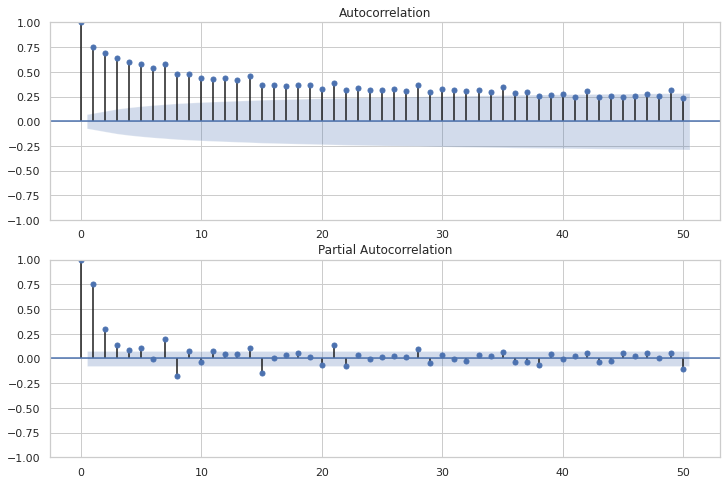

In [73]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(y_train_bc, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_train_bc, lags=50, ax=ax[1])

plt.show()

Попробуем избавиться от тренда взятием сезонной недельной разницы

In [74]:
y_train_diff_season = y_train_bc.diff(7).dropna()

In [75]:
adf = adfuller(y_train_diff_season)
ADF_stat = adf[0]
p_val = adf[1]
print('ADF Statistic:', ADF_stat, 'p_value:', p_val)

ADF Statistic: -8.662552650140501 p_value: 4.7789610190575496e-14


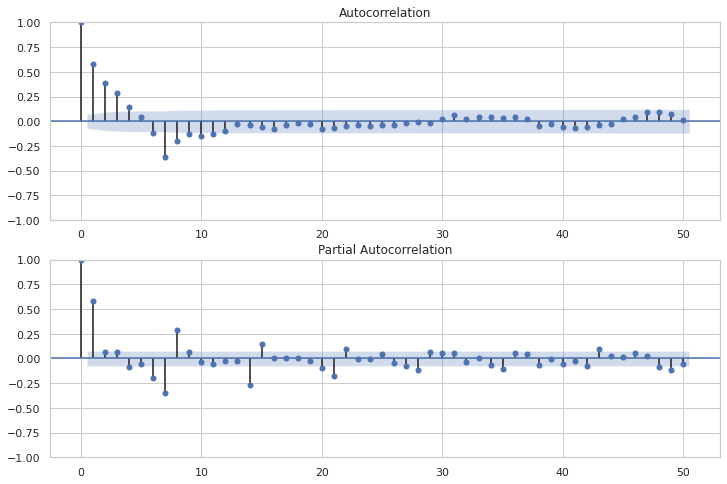

In [76]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(y_train_diff_season, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_train_diff_season, lags=50, ax=ax[1])

plt.show()

Ориентируясь на графики, перебором подобрали оптимальные значения

In [77]:
p=7
d=1
q=6
P=0
D=1
Q=0

In [78]:
model=ARIMA(y_train_bc, order=(7, 1, 6), 
                                      seasonal_order=(P, D, Q, 365)).fit(method='innovations_mle', low_memory=True, cov_type='none')

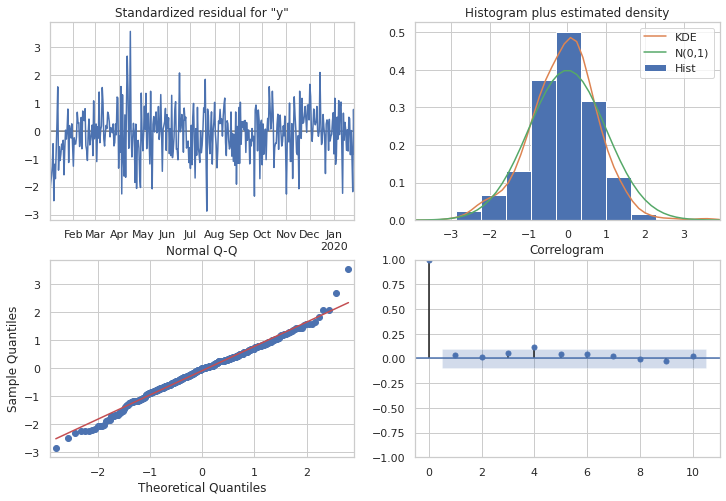

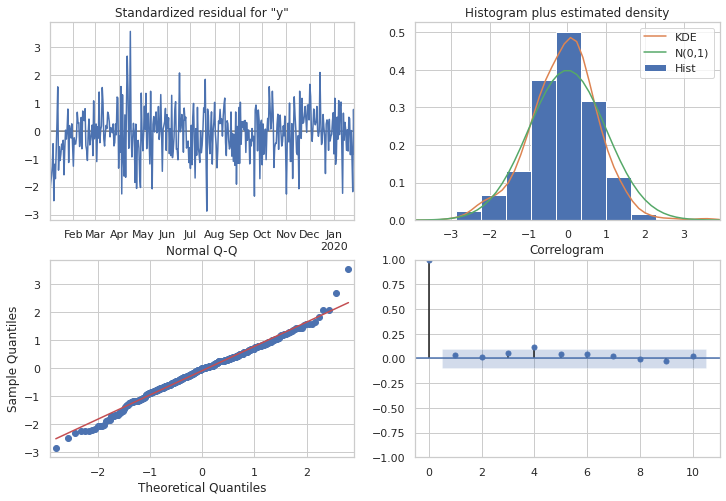

In [79]:
model.plot_diagnostics()

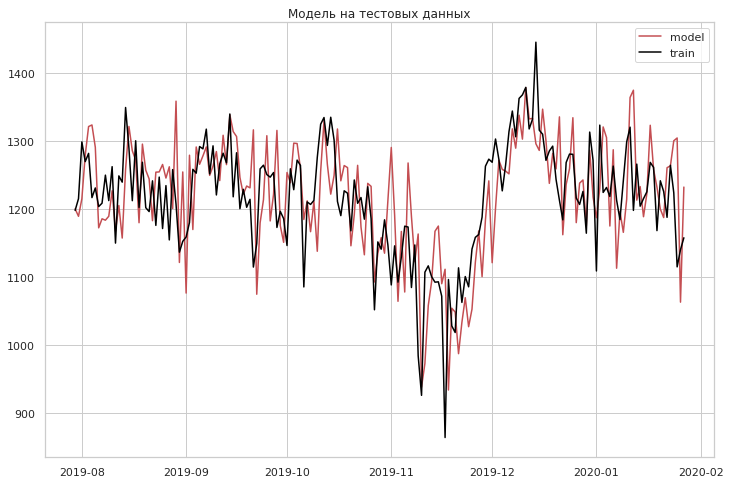

In [80]:
plt.plot(invboxcox(model.fittedvalues[-182:],lmbda), label='model', c='r')
plt.plot(y_train[-182:], label='train', c='black')
plt.legend()
plt.title('Модель на тестовых данных');

In [81]:
preds_test = invboxcox(model.predict(y_test.index.min(),y_test.index.max()),lmbda)
preds_valid =invboxcox(model.predict(y_valid.index.min(),y_valid.index.max()),lmbda)
metrics(y_test, preds_test)

Абсолютное значение отклонения цены продажи, MAE    129.81
Средний процент отклонения цены продажи, MAPE        12.29
Отклонение цены продажи, RMSE                       160.44
dtype: float64

Видим что абсолютная ошибка на тесте составляет ~130 рублей.

Посмотрим график предсказаний на валидационном месяце

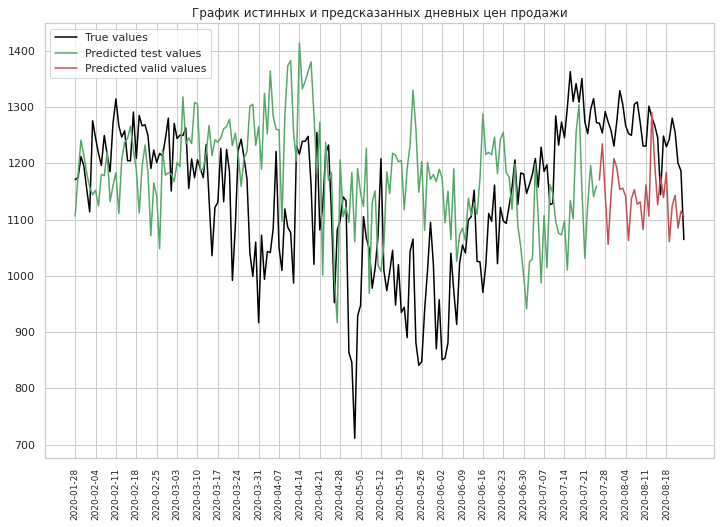

In [82]:
plt.subplot()

true = plt.plot(true_y_test_valid.index, true_y_test_valid, color='black', label='True values')
test = plt.plot(preds_test.index,preds_test,color='g', label='Predicted test values')
valid = plt.plot(preds_valid.index, preds_valid,color='r', label='Predicted valid values')

plt.xticks(true_y_test_valid.index[::7], fontsize=9, rotation=90)

plt.title('График истинных и предсказанных дневных цен продажи')
plt.legend()
plt.show()

Ошибка на валидационном месяце

In [83]:
metrics(y_valid, preds_valid)

Абсолютное значение отклонения цены продажи, MAE    113.70
Средний процент отклонения цены продажи, MAPE         9.00
Отклонение цены продажи, RMSE                       126.98
dtype: float64

Обобщающая способность имеется, но пока далека до идеала

# Заключение

1. Были построены модели экспоненциального сглаживания и АРИМА
2. Так же были построены модели линейной регрессии и градиентного бустинга
3. Линейная регрессия и бустинг имеют хорошую обобщающую способность, но требуют ежедневных данных для предсказаний
4. Модели временных рядов так же имеют обобщающую способность, но в предсказательной части не всегда способны угадать тренд

Что можно сделать еще?
1. Добиться от АРИМА более точных предсказаний, так как недельная сезонная разность не была использована. Видно, что в остатках еще остается структурированная информация, которую можно попробовать использовать
2. FB Prophet / Neuro Prophet
3. Выделить признаки для линейной регрессии и градиентного бустинга, на которых обучить модель предсказывать ряд. (Лаги, признаки из даты)
4. LSTM 